<a href="https://colab.research.google.com/github/vegsa/DAI_test/blob/main/Deep_active_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
import numpy as np
import math
import gym
from gym import spaces
from gym.utils import seeding
import copy

import matplotlib.pyplot as plt

# Environment 
class GridEnv(gym.Env):
    
    metadata = {'render.modes': ['humans']}
    
    def __init__(self, custom_map):
        super(GridEnv, self).__init__()

        # 0: 'W', 1: 'N' 2: 'E', 3: 'S', 4: 'SW', 5: 'NW', 6: 'NE', 7: 'SE', 8: Stay
        self.actions = [0, 1, 2, 3, 4, 5, 6, 7, 8]
        
        #Action space
        self.action_space = spaces.Discrete(len(self.actions))
        
        self.actions_pos_dict = {0: [0, -1], 1: [-1, 0], 2: [0, 1], 3: [1, 0], 4: [1, -1], 5: [-1, -1], 6: [-1, 1], 7: [1, 1], 8: [0, 0]}
        
        # Observation space
        #self.observation_space = spaces.Box(low=0, high=1, shape=(100,100), dtype=np.float32)
        
        self.n_width = len(custom_map[0])
        self.n_height = len(custom_map)
        
        self.observation_space = spaces.Discrete(self.n_width*self.n_height)
        
        self.start_state = (0,0) #(0,0)
        
        #self.goal_state = (17,13)  #(5,7) #(26,24) #(self.n_width-1,self.n_height-1)
        
        self.agent_state = copy.deepcopy(self.start_state)
                
        #States that cannot be hit
        self.obstacles, self.goal_state = self.get_obstacles_and_goal(custom_map)

        # Rewards: Goal, Fail, Energy, Closer to goal both direction, Closer to goal one direction, Stay
        self.rewards = [1.15, -2, -0.5, 0.7, 0.25, -0.5] #[1, -1, -0.1, 0.1, 0.05, -0.1] #[75, -75, -15, 10, 3, -15] #[5, -1, -0.1, 0.2, 0.1, -0.1] 
        # [5,-3,-0.1, 0.1, 0.05, -0.5]
        self.reset()
        self.seed()
        
        # Seeding
    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]
        
    def step(self, action):
        next_x, next_y = (self.agent_state[0] + self.actions_pos_dict[action][0],
                          self.agent_state[1] + self.actions_pos_dict[action][1])
        
        if next_x < 0:
            next_x = 0
        
        if next_x >= self.n_width:
            next_x = self.n_width-1
            
        if next_y < 0:
            next_y = 0
            
        if next_y >= self.n_height:
            next_y = self.n_height-1
            
        reward, done = self.get_reward(next_x, next_y)
        self.agent_state = next_x, next_y

        info ={'X: ': next_x, 'Y: ': next_y}
        
        return self.agent_state, reward, done, info
            
        
    def reset(self, start_state=(0,0)):
        self.agent_state = start_state
        return self.agent_state
        
    def render(self, mode='human'):
        pass
    
    def close(self):
        pass

    def xy_to_state(self, x, y):
        return y + self.n_width*x
    
    def state_to_xy(self, state):
        x = state//self.n_width
        y = state % self.n_width
        return x, y
    
    def get_reward(self, x, y):
        i, done = self.get_state_status(x,y)
        return self.rewards[i], done
    
    def get_state_status(self, x, y):
        
        if (x,y) in self.obstacles:
            return 1, True
        elif (x,y) == self.goal_state:
            return 0, True
        elif self.closer_to_goal(x,y):
            return 3, False
        elif self.closer_to_goal2(x,y):
            return 4, False
        elif (x,y) == self.agent_state:
            return 5, False
        else:
            return 2, False
        
    def get_obstacles_and_goal(self, custom_map):
        arr = []
        goal = (0,0)
        for i in range(self.n_height):
            for j in range(self.n_width):
                if custom_map[i,j] == 1:
                    arr.append((i,j))

                if custom_map[i,j] == 2:
                    goal = (i,j)

        print("Obstacles: ", arr)
        return arr, goal

    # Fix these two ways of assigning rewards when moving towards the goal.
    def closer_to_goal(self, new_x, new_y):
        x_old = abs(self.goal_state[0] - self.agent_state[0])
        y_old = abs(self.goal_state[1] - self.agent_state[1])

        x_new = abs(self.goal_state[0] - new_x)
        y_new = abs(self.goal_state[1] - new_y)
        
        if x_new < x_old and y_new < y_old:
            return True
        else:
            return False
    
    def closer_to_goal2(self, new_x, new_y):
        
        old = abs(self.goal_state[0] - self.agent_state[0]) + abs(self.goal_state[1] - self.agent_state[1])
        new = abs(self.goal_state[0] - new_x) + abs(self.goal_state[1] - new_y)
        
        if new < old:
            return True
        else:
            return False
            
    def return_goal_pos(self):
        #return self.xy_to_state(self.goal_state[0], self.goal_state[1])
        return self.goal_state


In [2]:
# Goal: (26, 24) / (6,24)
"""
custom_map = np.array([
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,1,1,1,1,1],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,1,1,1,1,1],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,1,1,1,1,1,1],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,1,1,1,1],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,1,0,0,0,1,1,1,1,1,1],
        [0,0,0,0,0,0,1,1,1,0,0,0,0,1,1,1,1,0,0,0,1,1,0,0,0,1,1,1,1,1],
        [0,0,0,0,0,0,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,0,0,0,0,0,1,1,1,1],
        [0,0,0,0,0,1,1,1,1,0,0,0,1,1,1,1,0,0,0,1,0,0,0,1,0,0,0,1,1,1],
        [0,0,0,0,0,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,0,0,1,1,0,0,0,1,1,1],
        [0,0,0,0,0,1,1,1,1,0,0,1,1,1,1,0,0,0,1,0,0,0,1,0,0,0,1,1,1,1],
        [0,0,0,0,1,1,1,1,0,0,0,1,1,1,1,0,0,1,1,0,0,1,1,0,0,1,1,1,1,1],
        [0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,0,0,1,0,0,2,1,1,1,1,1],
        [0,0,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,1,1,1,1,1,0,0,0,1,1,1,1,1],
        [0,0,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
        [0,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
    ])
"""
custom_map = np.array([
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1],
        [0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1],
        [0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1],
        [0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1],
        [0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1],
        [0,0,0,0,0,1,1,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1],
        [0,0,0,0,1,1,1,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1],
        [0,0,0,0,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,2,1,1,1,1,1],
        [0,0,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,1,1,1,1,1,0,0,0,1,1,1,1,1],
        [0,0,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
        [0,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
    ])

"""

#(17,13)
custom_map = np.array([
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1],
        [0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1],
        [0,1,1,1,1,0,0,0,0,0,0,0,0,2,0,1,1,1,1,1],
        [1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1],
        [1,1,1,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
    ])

custom_map = np.array([
        [0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,1,0,0,0,0],
        [0,0,0,0,0,0,0,0,1,0],
        [0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0],
        [1,0,0,0,0,0,0,2,0,0],
        [0,0,0,0,0,0,0,0,0,1],
        [0,0,0,1,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0],
        [1,0,0,0,0,1,0,0,0,1],
    ])
"""
N_WIDTH = 30
N_HEIGHT = 30

In [3]:
EPS_VAL = 1e-16
def log_stable2(arr):
    return np.log(arr + EPS_VAL)

def KL_divergence(q, p):
    KL = []
    for i in range(len(q)):
        KL_i =  np.sum(q[i]*(log_stable2(q[i]) - log_stable2(p[i])))
        KL.append([KL_i])
        
        #print("q: ", q[i], "p ", p[i], "KL: ", KL_i)
    return KL

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt

from collections import deque


class Model(nn.Module):

      def __init__(self, num_inputs, num_outputs, num_hidden=200, learning_rate=1e-3, softmax=False, relu_output=False, device='cpu'):  # device='cpu'
          super(Model, self).__init__()

          self.num_inputs = num_inputs
          self.num_hidden = num_hidden
          self.num_outputs = num_outputs
          self.softmax = softmax
          self.relu_output = relu_output

          self.fc1 = nn.Linear(self.num_inputs, self.num_hidden)  #Hidden layer
          self.fc12 = nn.Linear(self.num_hidden, self.num_hidden)
          #self.fc23 = nn.Linear(self.num_hidden, self.num_hidden)
          self.fc2 = nn.Linear(self.num_hidden, self.num_outputs) #Output layer

          self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
          self.device = device
          self.to(self.device)

      def forward(self, x):

          layer1 = F.relu(self.fc1(x))
          layer2 = F.relu(self.fc12(layer1))
          #layer3 = F.relu(self.fc23(layer2))
          #output = self.fc2(layer2)
          if self.softmax:
              output = F.softmax(self.fc2(layer2), dim=-1).clamp(min=1e-9, max=1-1e-9)
          elif self.relu_output:
              output = F.relu(self.fc2(layer2))
          else:
              output = self.fc2(layer2)
          return output


In [79]:
class Agent():

    def __init__(self, env):

        # Parameters of the environment
        self.obs_size = 2
        self.num_actions = env.action_space.n

        # Networks
        
        self.transition_net = Model(self.obs_size+1, self.obs_size, num_hidden=64, learning_rate=1e-3, softmax=False, relu_output=True)
        self.policy_net = Model(self.obs_size,self.num_actions, num_hidden=64, learning_rate=1e-3, softmax=True)    
        self.EFE_net = Model(self.obs_size,self.num_actions, num_hidden=64, learning_rate=1e-4, softmax=False) 
        self.EFE_target_net = copy.deepcopy(self.EFE_net)
        """
        self.transition_net, self.transnet_optimizer = self.network_init(self.obs_size+1,self.obs_size, num_hidden=200, softmax=False)
        self.policy_net, self.polnet_optimizer = self.network_init(self.obs_size,self.num_actions, num_hidden=200, softmax=True)    
        self.EFE_net, self.EFEnet_optimizer = self.network_init(self.obs_size,self.num_actions, num_hidden=200, softmax=False) 
        self.EFE_target_net = copy.deepcopy(self.EFE_net)
        """

        # Parameters for training the networks
        self.gamma = 0.9
        self.Beta = 0.99
        self.epsilon = 1.0
        self.min_explore = 0.001

        self.mem_size = 65536
        self.batch_size = 64
        self.max_moves = 1000
        self.sync_freq = 25

        self.step_count = 0
        self.steps = 0

        # Replay memory
        self.replay_mem = deque(maxlen=self.mem_size)

        self.EPS_value = 1e-16


    # Sample action from policy net and take it
    def sample_action(self, obs):
        
        if np.random.uniform(0,1) < self.epsilon:
            action = np.random.randint(0,9)
            #action = np.random.randint(0,16)
            #return torch.tensor([[action]])
        else:
            with torch.no_grad():
                policy = self.policy_net(obs)
                #efe = self.EFE_net(obs)
                #soft_efe = torch.softmax(-self.gamma*efe, dim=1).clamp(min=1e-9, max=1-1e-9)
                #return torch.multinomial(policy, 1)
                #print("policy in ",obs ,": ",policy)
                #print("p(a|s) in ", obs, ": ", soft_efe)
            action = np.argmax(policy.data.numpy())
        
        """
        with torch.no_grad():
            # Determine the action distribution given the current observation:
            policy = self.policy_net(obs)
            #print("Observation: ", obs)
            #print("Policy: ", policy)
            return torch.multinomial(policy, 1)
        """
        return torch.tensor([[action]])
    
    def network_init(self, num_input, num_output, num_hidden=64, softmax=False):
      
        layer1 = num_input
        layer2 = num_hidden
        layer3 = num_hidden
        layer4 = num_output

        if softmax:
            model = torch.nn.Sequential(
                torch.nn.Linear(layer1, layer2),
                torch.nn.Tanh(),
                torch.nn.Linear(layer2, layer3),
                torch.nn.Tanh(),
                torch.nn.Linear(layer3, layer4),
                torch.nn.Softmax(dim=1)
                )
        else:
            model = torch.nn.Sequential(
                torch.nn.Linear(layer1, layer2),
                torch.nn.Tanh(),
                torch.nn.Linear(layer2, layer3),
                torch.nn.Tanh(),
                torch.nn.Linear(layer3, layer4)
                )

        learning_rate = 0.001
        optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)    
        
        return model, optimizer

    def get_batches(self):
        minibatch = random.sample(self.replay_mem, self.batch_size)
        
        obs_t0_batch = torch.cat([s0 for (s0,a0,s1,r1,a1,s2,d) in minibatch])
        #print("obs_t0: ", obs_t0_batch)
        action_t0_batch = torch.cat([a0 for (s0,a0,s1,r1,a1,s2,d) in minibatch])
        #print("action_t0: ", action_t0_batch)
        obs_t1_batch = torch.cat([s1 for (s0,a0,s1,r1,a1,s2,d) in minibatch])
        #print("obs_t1: ", obs_t1_batch)
        reward_t1_batch = torch.Tensor([r1 for (s0,a0,s1,r1,a1,s2,d) in minibatch])
        reward_t1_batch = reward_t1_batch.expand(1,self.batch_size)
        reward_t1_batch = torch.transpose(reward_t1_batch,0,1)
        #print("reward_t1: ", reward_t1_batch)

        action_t1_batch = torch.cat([a1 for (s0,a0,s1,r1,a1,s2,d) in minibatch])
        #print("action_t1: ", action_t1_batch)
        obs_t2_batch = torch.cat([s2 for (s0,a0,s1,r1,a1,s2,d) in minibatch])
        #print("obs_t2: ", obs_t2_batch)
        done_batch = torch.Tensor([d for (s0,a0,s1,r1,a1,s2,d) in minibatch])
        done_batch = done_batch.expand(1,self.batch_size)
        done_batch = torch.transpose(done_batch,0,1)
        #print("done_batch: ", done_batch)
        
        state_and_action = torch.cat((obs_t0_batch, action_t0_batch.float()),dim=1) #
        pred_state_t1_batch = self.transition_net(state_and_action) # Predict the next state with the transition network
        pred_state_error_t1 = torch.mean(F.mse_loss(pred_state_t1_batch, obs_t1_batch, reduction='none'),dim=1).unsqueeze(1)
        #print("---")
        #print("pred_error: ", pred_state_t1_batch)
        #print("obs_t1: ", obs_t1_batch)


        pred_state_nump = pred_state_t1_batch.detach().numpy()
        obs_t1_nump = obs_t1_batch.detach().numpy()

        #KL = KL_divergence(pred_state_nump, obs_t1_nump)
        #KL = torch.tensor(KL)
        #print("D_KL", KL)

        return obs_t0_batch, action_t0_batch, obs_t1_batch, reward_t1_batch, action_t1_batch, obs_t2_batch, done_batch, pred_state_error_t1    #, KL

    def compute_EFE_net_loss(self,obs_t1_batch, reward_t1_batch, action_t0_batch, action_t1_batch, obs_t2_batch, done_batch, pred_state_error_t1):

        with torch.no_grad():
            policy_t2_batch = self.policy_net(obs_t2_batch)
            target_EFE_t2_batch = self.EFE_target_net(obs_t2_batch)
            weighted_targets = ((1-done_batch)*policy_t2_batch*target_EFE_t2_batch).sum(-1).unsqueeze(1)
            EFE_estimate_batch = -reward_t1_batch + pred_state_error_t1 + self.Beta*weighted_targets #KL
        #print("EFE_est: ", EFE_estimate_batch)
        #print("reward_t1: ", reward_t1_batch)
        #print("pred_state_error: ", pred_state_error_t1)
        #print("weights: ", weighted_targets)
        #print("obs_t1: ", obs_t1_batch)
        EFE_t1_batch = self.EFE_net(obs_t1_batch).gather(1,action_t1_batch) # Check this out
        
        #print("obs_t1: ", obs_t1_batch)
        #print("EFE_t1_batch: ", EFE_t1_batch)
        
        L = F.mse_loss(EFE_estimate_batch, EFE_t1_batch)
        return L

    def compute_VFE(self, obs_t1_batch, pred_error_batch):

        policy_t1_batch = self.policy_net(obs_t1_batch)

        EFE_t1_batch = self.EFE_net(obs_t1_batch).detach()

        softmax_EFE_t1_batch = torch.softmax(-self.gamma*EFE_t1_batch, dim=1).clamp(min=1e-9, max=1-1e-9) #clamp

        energy_batch = -(policy_t1_batch*torch.log(softmax_EFE_t1_batch)).sum(-1).view(self.batch_size,1)

        entropy_batch = -(policy_t1_batch*torch.log(policy_t1_batch)).sum(-1).view(self.batch_size,1)

        VFE_batch = pred_error_batch + (energy_batch - entropy_batch)
        #VFE_batch = KL + (energy_batch - entropy_batch)

        VFE = torch.mean(VFE_batch)
        return VFE
    
    def learn(self):

        if self.step_count % self.sync_freq == 0:
            self.EFE_target_net.load_state_dict(self.EFE_net.state_dict())

        obs_t0_batch, action_t0_batch, obs_t1_batch, reward_t1_batch, action_t1_batch, obs_t2_batch, done_batch, pred_state_error_t1 = self.get_batches()

        EFE_loss = self.compute_EFE_net_loss(obs_t1_batch, reward_t1_batch, action_t0_batch, action_t1_batch, obs_t2_batch, done_batch, pred_state_error_t1)
        #print("EFE_loss: ", EFE_loss)

        VFE = self.compute_VFE(obs_t1_batch, pred_state_error_t1)
        
        self.transition_net.optimizer.zero_grad()
        self.policy_net.optimizer.zero_grad()
        self.EFE_net.optimizer.zero_grad()
        """
        self.transnet_optimizer.zero_grad()
        self.polnet_optimizer.zero_grad()
        self.EFEnet_optimizer.zero_grad()

        VFE.backward()    
        EFE_loss.backward()  

        self.transnet_optimizer.step()
        self.polnet_optimizer.step()
        self.EFEnet_optimizer.step()
        """
        VFE.backward()    
        EFE_loss.backward()  

        self.transition_net.optimizer.step()
        self.policy_net.optimizer.step()
        self.EFE_net.optimizer.step()
        
    def train_networks(self, episodes):
        rewards = []
        goal_count = 0
        counter = 0
        epsilon_adjust = 1
        epsilon_reset = False

        for i in range(episodes):
            print("---------------Episode: ", i, "---------------")
            """
            if goal_count < 100:
                obs_t0 = env.reset((24,24))
            #elif goal_count < 100:
            #    obs_t0 = env.reset((21,24))
            elif goal_count < 200:
                obs_t0 = env.reset((19,22))
            #elif goal_count < 200:
            #    obs_t0 = env.reset((17,21))
            elif goal_count < 300:
                obs_t0 = env.reset((14,20))
            #elif goal_count < 300:
            #    obs_t0 = env.reset((10,15))
            else:
                obs_t0 = env.reset()
            """
            obs_t0 = env.reset()
            obs_t0 = torch.from_numpy(np.array([obs_t0[0], obs_t0[1]]).reshape(1,self.obs_size)).float()
            #obs_t0 = torch.tensor(obs_t0, dtype=torch.float32, device='cpu')
            

            action_t0 = self.sample_action(obs_t0)

            obs_t1, reward_t1, done1, _ = env.step(action_t0[0].item())  #done1
            obs_t1 = torch.from_numpy(np.array([obs_t1[0], obs_t1[1]]).reshape(1,self.obs_size)).float()
            #done = False
            obs_t2 = obs_t1
            self.steps = 0
            while (not done1) and (self.steps < self.max_moves): #done1
                #print("Step ", steps)
                self.steps += 1
                """
                action_t0 = self.sample_action(obs_t0)

                obs_t1, reward_t1, done_t1, _ = env.step(actiont_0[0].item)
                obs_t1 = torch.from_numpy(np.array([obs_t1[0], obs_t1[1]]).reshape(1,layer1)).float()
                """

                action_t1 = self.sample_action(obs_t1)
                
                #print("actiont1: ", action_t1[0].item())
                obs_t2, reward_t2, done2, _ = env.step(action_t1[0].item()) # done2
                #print("Obs_t2: ", obs_t2)
                obs_t2 = torch.from_numpy(np.array([obs_t2[0], obs_t2[1]]).reshape(1,self.obs_size)).float()

                obs_check = obs_t2.numpy()[0]
                obs_check_nump = (int(obs_check[0]), int(obs_check[1]))
                #print("obs_check: ", obs_check_nump)

                exp = (obs_t0, action_t0, obs_t1, reward_t1, action_t1, obs_t2, done1) #done1
                self.replay_mem.append(exp)

                self.step_count += 1

                if len(self.replay_mem) > self.batch_size:
                    self.learn()

                obs_t0 = obs_t1
                obs_t1 = obs_t2

                reward_t1 = reward_t2
                action_t0 = action_t1
                done1 = done2
                if done1: #done1
                    #exp = (obs_t0, action_t0, obs_t1, reward_t1, torch.tensor([[8]]), obs_t1, done1) #done1
                    exp = (obs_t0, action_t0, obs_t1, reward_t1, action_t0, obs_t1, done1)
                    self.replay_mem.append(exp)

            observ = obs_t2.numpy()[0]
            obs_to_nump = (int(observ[0]), int(observ[1]))
            if obs_to_nump == env.return_goal_pos():
                goal_count += 1
            print("End state: ", obs_to_nump)
            print("Steps: ", self.steps)
            print("Goal count: ", goal_count)
            
            self.epsilon = max(self.min_explore, np.exp(-0.002*counter))
            print("Epsilon: ", self.epsilon)
            counter += 1
            """
            #if counter % 1000 == 0:
            if (goal_count % 100 == 0) and (goal_count <= 300) and epsilon_reset:
                counter = 0
                epsilon_reset=False
            
            if (goal_count % 100 == 1):
                epsilon_reset = True
            """
    
        return self.policy_net
        

In [ ]:
episodes = 1500

env = GridEnv(custom_map)

agent = Agent(env)

policy_net = agent.train_networks(episodes)

Obstacles:  [(9, 29), (10, 28), (10, 29), (11, 26), (11, 27), (11, 28), (11, 29), (12, 25), (12, 26), (12, 27), (12, 28), (12, 29), (13, 25), (13, 26), (13, 27), (13, 28), (13, 29), (14, 24), (14, 25), (14, 26), (14, 27), (14, 28), (14, 29), (15, 23), (15, 24), (15, 25), (15, 26), (15, 27), (15, 28), (15, 29), (16, 23), (16, 24), (16, 25), (16, 26), (16, 27), (16, 28), (16, 29), (17, 23), (17, 24), (17, 25), (17, 26), (17, 27), (17, 28), (17, 29), (18, 24), (18, 25), (18, 26), (18, 27), (18, 28), (18, 29), (19, 24), (19, 25), (19, 26), (19, 27), (19, 28), (19, 29), (20, 6), (20, 7), (20, 8), (20, 25), (20, 26), (20, 27), (20, 28), (20, 29), (21, 6), (21, 7), (21, 8), (21, 9), (21, 26), (21, 27), (21, 28), (21, 29), (22, 5), (22, 6), (22, 7), (22, 8), (22, 27), (22, 28), (22, 29), (23, 5), (23, 6), (23, 7), (23, 8), (23, 27), (23, 28), (23, 29), (24, 5), (24, 6), (24, 7), (24, 8), (24, 11), (24, 12), (24, 26), (24, 27), (24, 28), (24, 29), (25, 4), (25, 5), (25, 6), (25, 7), (25, 11), (

In [82]:
def active_inference(env, open_states, policy_net):
    episodes = 1#len(open_states)
    score = 0
    total_reward = []
    average_reward = []
    number_of_steps = []
    actions = []
    not_hit = []
    path = []
    for k in range(episodes):
        num_steps = 0
        start_st = (0,0)#open_states[k]
        state = env.reset(start_st)
        done = False
        reward_count = 0
        while (not done) and (num_steps < 50):
            path.append(state)
            #action = np.random.choice([0,1,2,3,4,5,6,7,8], p=Q_pi[i,:, state])
            action = sample_action_(state, policy_net)
            #print(Q_pi[i,:,state])
            actions.append(action.item())
            new_state, reward, done, _ = env.step(action.item())
            print("Reward: ", reward)
            reward_count += reward
            state = new_state
            print(state)
            num_steps += 1
            if done:
                goals = env.return_goal_pos()
                if state == goals:
                    score += 1
                else:
                    print("FAIL")
                    not_hit.append(start_st)

        total_reward.append(reward_count)
        average_reward.append(np.mean(total_reward))
        number_of_steps.append(num_steps)
    
    plt.figure(1)
    plt.plot(average_reward)
    plt.grid()
    plt.xlabel(' Open State number')
    plt.ylabel('Average reward')

    plt.figure(2)
    plt.plot(number_of_steps)
    plt.grid()
    plt.xlabel('State number')
    plt.ylabel('Number of steps used to goal')
    print("Max: ", np.amax(number_of_steps))
    print("The agent reached the goal {} out of 650 times".format(score))
    print(number_of_steps[0])
    print(not_hit)

    print("Actions: ", actions)
    print("Path: ", path)

def sample_action_(obs, policy_net):
    obs = torch.from_numpy(np.array([obs[0], obs[1]]).reshape(1,2)).float()

    actions = policy_net(obs)    # Action distribution given the observation
    print("Actions: ", actions)
    return torch.argmax(actions)  # Sample one action from the action distribution



Obstacles:  [(9, 29), (10, 28), (10, 29), (11, 26), (11, 27), (11, 28), (11, 29), (12, 25), (12, 26), (12, 27), (12, 28), (12, 29), (13, 25), (13, 26), (13, 27), (13, 28), (13, 29), (14, 24), (14, 25), (14, 26), (14, 27), (14, 28), (14, 29), (15, 23), (15, 24), (15, 25), (15, 26), (15, 27), (15, 28), (15, 29), (16, 23), (16, 24), (16, 25), (16, 26), (16, 27), (16, 28), (16, 29), (17, 23), (17, 24), (17, 25), (17, 26), (17, 27), (17, 28), (17, 29), (18, 24), (18, 25), (18, 26), (18, 27), (18, 28), (18, 29), (19, 24), (19, 25), (19, 26), (19, 27), (19, 28), (19, 29), (20, 6), (20, 7), (20, 8), (20, 25), (20, 26), (20, 27), (20, 28), (20, 29), (21, 6), (21, 7), (21, 8), (21, 9), (21, 26), (21, 27), (21, 28), (21, 29), (22, 5), (22, 6), (22, 7), (22, 8), (22, 27), (22, 28), (22, 29), (23, 5), (23, 6), (23, 7), (23, 8), (23, 27), (23, 28), (23, 29), (24, 5), (24, 6), (24, 7), (24, 8), (24, 11), (24, 12), (24, 26), (24, 27), (24, 28), (24, 29), (25, 4), (25, 5), (25, 6), (25, 7), (25, 11), (

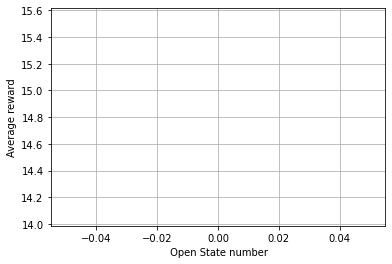

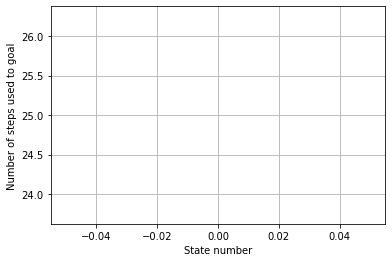

In [83]:
obstacles = env.get_obstacles_and_goal(custom_map)
open_states = []

for i in range(10):
    for j in range(10):
        if (i,j) not in obstacles:
            open_states.append(j + 10*i)

active_inference(env, open_states, policy_net)

In [ ]:
f = torch.tensor([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
print(f)


f = f.expand(1,25)
print(f)

f = torch.transpose(f,0,1)
print(f)


tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0]])
tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]])


In [66]:
l = [0.4339, 0.7716, 0.8642, 0.6308, 1.0100, 0.7703, 0.3682, 0.5911, 0.4441]
s = 0
for i in range(len(l)):
    s += l[i]

print(s)

5.884199999999999


In [50]:
t = np.exp([1.15, -2, -0.5, 0.7, 0.25, -0.5])

sm = softmax(t)

print(sm)

[0.5964983  0.02902678 0.04649822 0.18992632 0.09155216 0.04649822]
